In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import linear_model, ensemble, discriminant_analysis
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score

from functions.pipeline import *

In [2]:
SEED = 123
np.random.seed(SEED)

In [3]:
p = os.path.dirname(os.path.realpath(__name__))
path = f"{p}/data/data.csv"
df = pd.read_csv(path)
matrix, target = Gx.processing(df)

In [4]:
df.head(2)

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127


In [5]:
matrix.head(2)

left_ankle  left_knee   left_hip  right_ankle  right_knee  \
trial time                                                              
1     0       4.682881   3.693683  16.607868     5.015829    2.244425   
      1       5.073127   4.258876  16.851029     5.291201    3.381678   

            right_hip  
trial time             
1     0      18.94829  
      1      19.26530

In [6]:
target.head(2)

1    1
2    1
Name: condition, dtype: int64

<Axes: xlabel='time'>

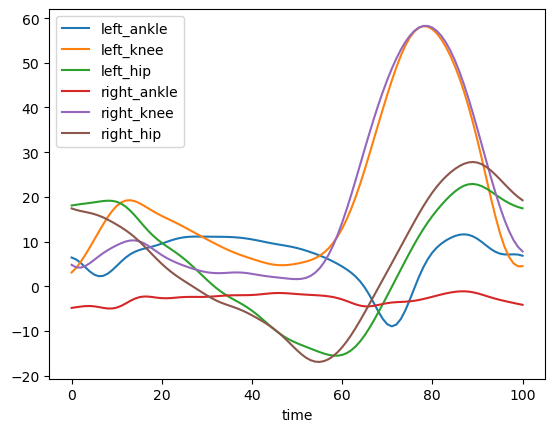

In [7]:
# knee brace
subject_no = 1
condition_no = 3
rep_no = 5
idx = (N_REPS * N_CONDITIONS) * (subject_no - 1) + N_REPS * (condition_no - 1) + (rep_no % N_REPS)
matrix.loc[idx, :].plot()

# Feature Extraction

In [8]:
means = matrix.groupby("trial").mean()
means.columns=[f"{col}_mean" for col in matrix.columns]
stdevs = matrix.groupby("trial").std()
stdevs.columns=[f"{col}_stdev" for col in matrix.columns]

In [9]:
stdev_ra = matrix["right_ankle"].groupby("trial").std()
stdev_rk = matrix["right_knee"].groupby("trial").std()

In [11]:
# need to write the code to set up all the parts of the covariance/correlation features (by splitting the matrix into 1, 2, 3 and 4 parts)

In [32]:
time_splits = Gx.get_time_splits(matrix, 2)
time_splits[1] # need to apply features to each element of time_splits

left_ankle  left_knee   left_hip  right_ankle  right_knee  \
trial time                                                              
1     50     13.167916   5.389025 -12.065175    13.451293    7.593185   
      51     13.280866   5.573957 -12.708399    13.547248    8.104331   
      52     13.358667   5.892645 -13.323654    13.584862    8.716051   
      53     13.369976   6.331077 -13.915811    13.531314    9.455649   
      54     13.295140   6.888184 -14.477692    13.364414   10.358133   
...                ...        ...        ...          ...         ...   
300   96      5.469052   0.964147  25.046914    -4.136161    2.616228   
      97      5.994900  -1.377103  24.753520    -4.050542    0.721412   
      98      6.625519  -2.884798  24.636438    -3.933841   -0.629712   
      99      7.293149  -3.532651  24.695275    -3.837398   -1.438054   
      100     7.877814  -3.379236  24.901665    -3.823557   -1.747282   

            right_hip  
trial time             
1     50   -12.208584  
      51   -12.565649  
      52   -12.888644  
      53   -13.169307  
      54   -13.387933  
...               ...  
300   96    29.778412  
      97    29.247559  
      98    28.796951  
      99    28.432936  
      100   28.136438  

[15300 rows x 6 columns]

In [61]:
n_time_splits = 2
time_splits = Gx.get_time_splits(matrix, n_time_splits)
corrs = pd.DataFrame()
covs = pd.DataFrame()

for i in range(n_time_splits):
    for body_part in ["ankle", "knee"]:
        
        band = time_splits[i]

        body_parts = band[[f"left_{body_part}", f"right_{body_part}"]]
        corrs[f"{body_part}_{i}"] = body_parts.groupby(["trial"]).corr(method="pearson").groupby("trial")[f"right_{body_part}"].first()
        covs[f"{body_part}_{i}"] = body_parts.groupby(["trial"]).cov().groupby("trial")[f"right_{body_part}"].first()

In [62]:
covs

,ankle_0,knee_0,ankle_1,knee_1
trial,,,,
1,13.365133,20.845941,25.749116,432.155556
2,10.880072,18.453050,27.777743,459.040831
3,13.108196,18.670196,34.689630,468.545144
4,11.811998,16.934188,29.393908,491.830740
5,12.641388,13.377137,28.940949,476.023788
...,...,...,...,...
296,3.997201,32.438157,6.692269,367.143167
297,3.439986,33.740020,8.829705,408.962964
298,4.579553,25.674669,14.561684,438.134983


In [63]:
# two sets of features:
# base: mean of some of the sensors
# correlation model

# split the data into bands and then apply features to each band

# Testing Model

In [64]:
model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, min_impurity_decrease=0, 
                                        bootstrap=False, criterion="log_loss")
# model = discriminant_analysis.LinearDiscriminantAnalysis(solver="svd")
# model = linear_model.LogisticRegression(max_iter=1000, multi_class="multinomial") 


In [65]:
features = pd.concat([covs], axis=1)
X_train, y_train, X_test, y_test = Gx.train_test_split(features, target)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(210, 4) (210,)
(90, 4) (90,)


In [66]:
# here we will use cross validation, leaving out 1 subject each time!
n_folds = TRAIN_SUBJECTS
cv_splits = Gx.cross_validation_splits(X_train, y_train, n_folds)
errors_valid = np.zeros(n_folds)

for i in range(len(cv_splits)):
   
   CV_X_train, CV_y_train, CV_X_valid, CV_y_valid = cv_splits[i].values()
   errors_valid[i], y_probs = Gx.run_model(CV_X_train, CV_y_train, CV_X_valid, CV_y_valid, model)

errors_valid

For fold 0
	train_inputs.shape = (180, 4)
	train_targets.shape = (180,)
	valid_inputs.shape = (30, 4)
	valid_targets.shape = (30,)
Accuracy: 0.7
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.9333333333333333
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


array([0.46512558, 0.0758829 , 0.00800704, 0.14075403, 0.04559369,
       0.00734039, 0.17033122])

In [67]:
error_test, y_test_probs = Gx.run_model(X_train, y_train, X_test, y_test, model)
error_test

Accuracy: 1.0


0.007722630346173203

<Axes: >

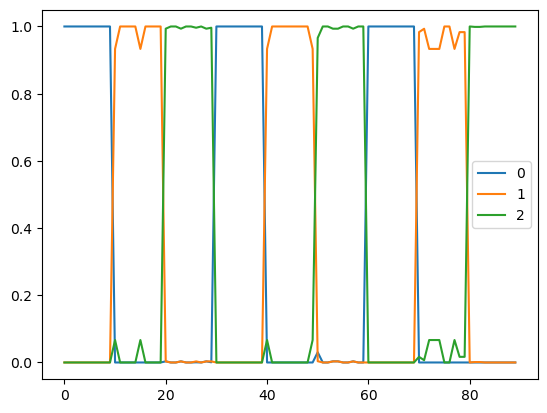

In [68]:
pd.DataFrame(y_test_probs).plot()

In [20]:
# ten subjects
# ten replications
# three conditions

# 6 measurements for each one (two legs, three joints)
# time series are 101 points long
# so the data is actually (300 x 101 x 6), so we should represent it as such.

# train-test split: 
# 7 subjects for train: should do leave-one-out validation (as in 1 subject each time)
# 3 subjects for test: leave three subjects for test

In [21]:
# to do:

# create cov features by splitting the data (e.g. first half / second half)